In [1]:
import pickle
import random

import pyleoclim as pyleo
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import ammonyte as amt
from tqdm import tqdm

# Top Panel

In [2]:
#Defining group lists for easy loading
group_names = ['ODP 925']

Time axis values sorted in ascending order


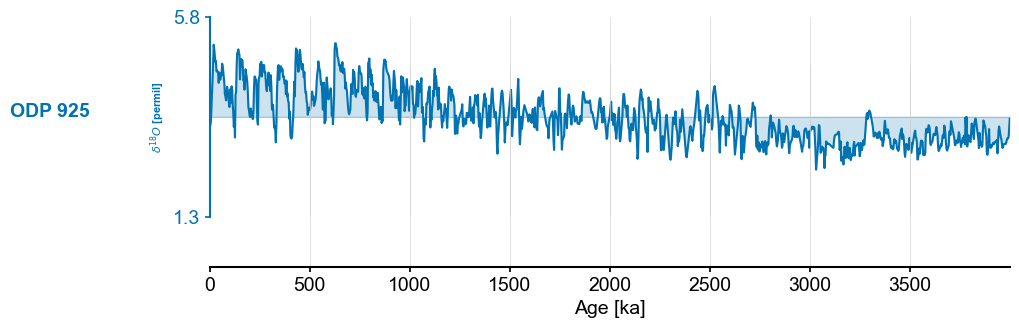

In [3]:
series_list = []
color_list = sns.color_palette('colorblind')

for name in group_names:
    with open('./data/LR04cores_spec_corr/'+name[-3:]+'_LR04age.txt','rb') as handle:
        lines = handle.readlines()
        time = []
        d18O = []
        for x in lines:
            line_time = float(format(float(x.decode().split()[1]),'10f'))
            line_d18O = float(format(float(x.decode().split()[2]),'10f'))
            #There is a discontinuity in 927 around 4000 ka, we'll just exclude it
            if line_time <= 4000:
                time.append(line_time)
                d18O.append(line_d18O)
        series = pyleo.Series(value=d18O,
                              time=time,
                              label=name,
                              time_name='Yr',
                              time_unit='ka',
                              value_name=r'$\delta^{18}O$',
                              value_unit='permil')
    series_list.append(series)
    
max_time = min([max(series.time) for series in series_list])
min_time = max([min(series.time) for series in series_list])

ms = pyleo.MultipleSeries([series.slice((min_time,max_time)).interp() for series in series_list])
fig,ax = ms.stackplot(colors=color_list[:len(ms.series_list)],figsize=(8,2*len(ms.series_list)))

In [4]:
with open('./data/0_2500_I65_staged.pkl','rb') as handle:
    initial_series = pickle.load(handle)

In [5]:
odp_series = ms.series_list[0]
binned_series = initial_series.bin(time_axis=odp_series.time)

/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:3906: UserWarning: no_nans is set to True but nans are present in the series. It has likely been overridden by other parameters. See tsutils.bin() documentation for details on parameter hierarchy
  res_dict = tsutils.bin(self.time,self.value,**kwargs)


In [6]:
def noise_test(series,sn_ratio=1,m=13,tau=None,w_size=50,w_incre=5,find_eps_kwargs=None):
    """Run a noise test
    
    Parameters
    ----------
    
    series : pyleo.Series
        Series on which to apply noise test
        
    sn_ratio : float
        Signal to noise ratio to use.
        Note that signal to noise is defined as the standard deviation of the series 
        divided by the standard deviation of the noise
        
    m : int
        Embedding dimension
        
    tau : int
        Time delay embedding
        
    w_size : int
        Window size
        
    w_incre : int
        Window increment
        
    find_eps_kwargs : dict
        Dictionary of arguments for amt.TimeEmbeddedSeries.find_epsilon"""
    
    find_eps_kwargs = {} if find_eps_kwargs is None else find_eps_kwargs.copy()
    if 'eps' not in find_eps_kwargs:
        find_eps_kwargs['eps'] = 1

    noise_time,noise_value = pyleo.utils.gen_ts(model='ar1',t=series.time,scale=series.stats()['std']/sn_ratio)
    noise = pyleo.Series(noise_time,noise_value,label='Noise Series',sort_ts=None)
    real_sn_ratio = series.stats()['std']/noise.stats()['std']
    noisy_series = series.copy()
    noisy_series.value += noise.value
    amt_series = amt.Series(
        time=noisy_series.time,
        value=noisy_series.value,
        time_name = noisy_series.time_name,
        value_name = noisy_series.value_name,
        time_unit = noisy_series.time_unit,
        value_unit = noisy_series.value_unit,
        label = noisy_series.label,
        sort_ts=None
    )
    amt_series.convert_time_unit('Years')
    td = amt_series.embed(m)
        
    eps = td.find_epsilon(**find_eps_kwargs,parallelize=False)
    rm = eps['Output']
    lp_series = rm.laplacian_eigenmaps(w_size,w_incre)
    lp_series.convert_time_unit('ka')
    
    return lp_series, noisy_series, real_sn_ratio

In [7]:
sn_ratio = 2
find_eps_kwargs = {'eps':5}

lp_series_2,noisy_series_2,real_sn_ratio_2 = noise_test(binned_series,
                                                        sn_ratio=sn_ratio,
                                                        find_eps_kwargs=find_eps_kwargs)

/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:153: UserWarning: No time_unit parameter provided. Assuming years CE.
  warnings.warn(f'No time_unit parameter provided. Assuming {time_unit}.', UserWarning)
/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


NaNs have been detected and dropped.
Initial density is 0.2791
Initial density is not within the tolerance window, searching...
Epsilon: 2.7089, Density: 0.0058
Epsilon: 3.1512, Density: 0.0158
Epsilon: 3.4933, Density: 0.0328
Epsilon: 3.6653, Density: 0.0461
Epsilon: 3.6653, Density: 0.0461.


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [kyr BP]', ylabel='Ice Volume'>)

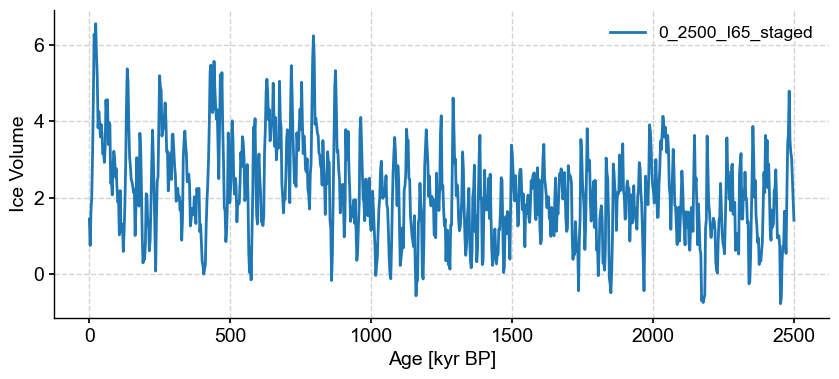

In [8]:
noisy_series_2.plot()

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Age [kyr BP]', ylabel='Fisher Information [None]'>)

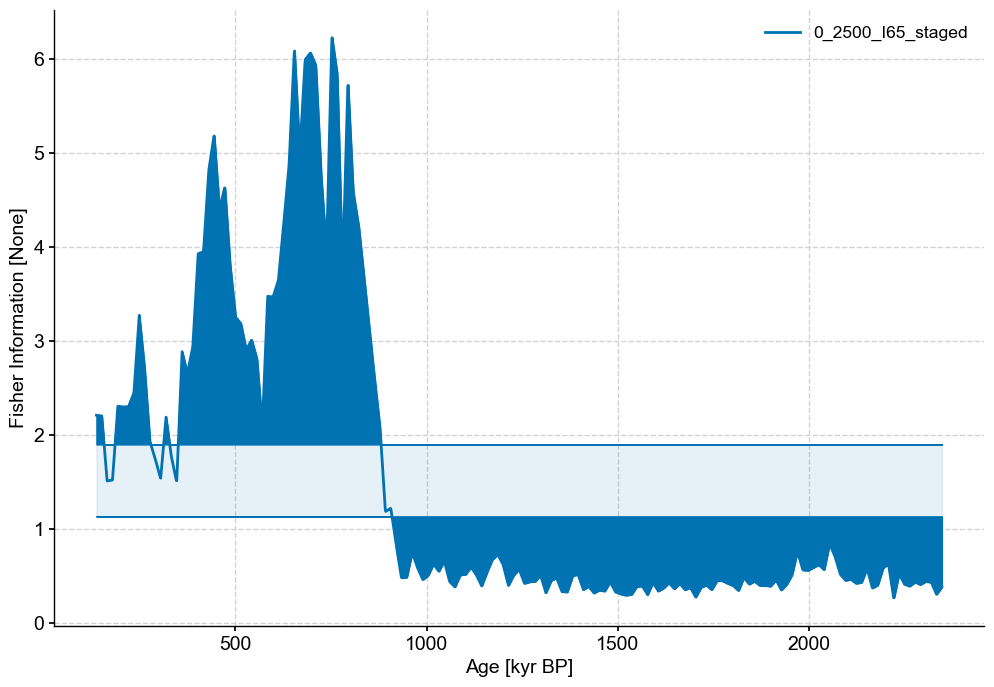

In [9]:
lp_series_2.confidence_fill_plot()

# Middle panel

In [10]:
with open('./data/0_2500_I65_stable.pkl','rb') as handle:
    initial_series = pickle.load(handle)

In [11]:
stable_series = initial_series.bin(bin_size=4)
stable_series.label = 'Stable Series'

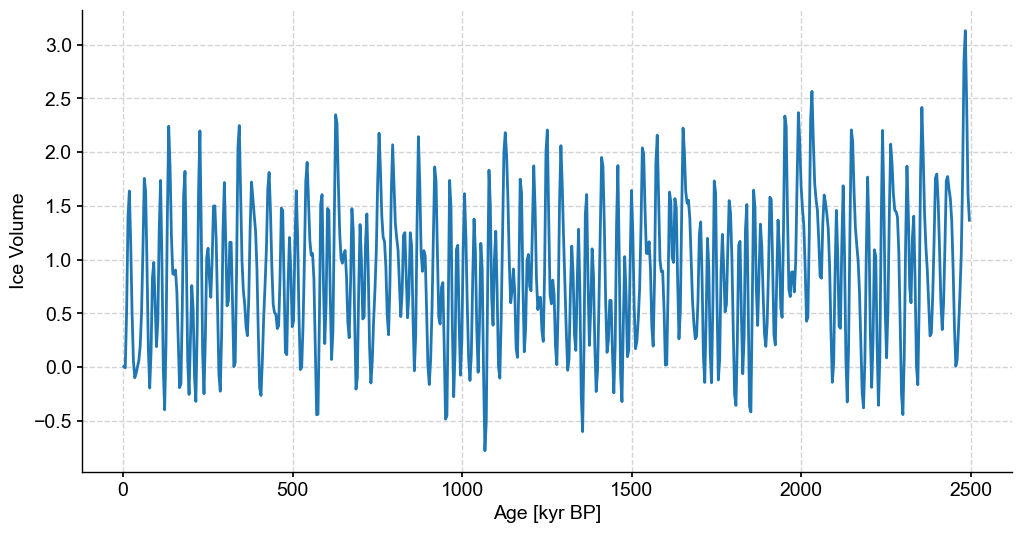

In [12]:
fig,ax = stable_series.plot(figsize=(12,6),legend=False)

In [13]:
series = stable_series
m=12

amt_series = amt.Series(
    time=series.time,
    value=series.value,
    time_name = series.time_name,
    value_name = series.value_name,
    time_unit = series.time_unit,
    value_unit = series.value_unit,
    label = series.label,
    clean_ts=False
).convert_time_unit('Years')
td = amt_series.embed(m)
eps = td.find_epsilon(1,.05,.01,parallelize=False)
rm = eps['Output']
lp_stable = rm.laplacian_eigenmaps(50,5).convert_time_unit('ka')

Time axis values sorted in ascending order
Initial density is 0.0022
Initial density is not within the tolerance window, searching...
Epsilon: 1.4781, Density: 0.0099
Epsilon: 1.8788, Density: 0.0403
Epsilon: 1.8788, Density: 0.0403.


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


Text(0.5, 0, 'Age [kyr BP]')

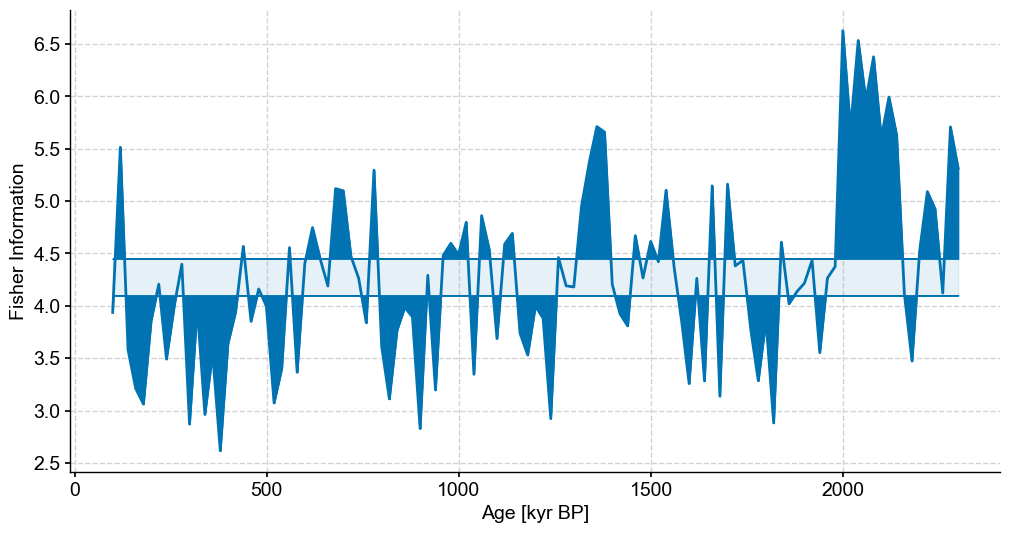

In [14]:
fig,ax = plt.subplots(figsize=(12,6))

lp_stable.confidence_fill_plot(ax=ax,legend=False)
ax.set_ylabel('Fisher Information')
ax.set_xlabel('Age [kyr BP]')

# Bottom panel

In [15]:
def remove_values(series,percent,seed=42,subset=None):
    '''Function to remove values at random
    
    Note that this currently assumes units of Years BP
    
    Parameters
    ----------
    
    series : pyleoclim.Series
        Series to remove values from
        
    percent : float
        Percentage of values to remove. Should be between 0 and 100
    
    seed : int
        Random seed to use
        
    subset : list
        [Start,stop] time indices for section of series you wish to be randomly coarsened. 
        If not passed, the whole series will be coarsened
        
    Returns
    -------
    
    sparse_series : pyleoclim.Series
    '''
    
    random.seed(seed)
    sparse_series = series.copy()
    
    if subset:
        sparse_slice = series.slice(subset)
        sparse_index = np.where((series.time >= sparse_slice.time[0]) & (series.time <= sparse_slice.time[-1]))[0]
        num_drop = int(len(sparse_slice.time) * (percent/100))
        index_drop = sorted(random.sample(range(sparse_index[0],sparse_index[-1]), num_drop))
        time = np.delete(series.time,index_drop)
        value = np.delete(series.value,index_drop)
        sparse_series.time = time
        sparse_series.value = value
        
    else:   
        num_drop = int(len(series.time) * (percent/100))
        index_drop = sorted(random.sample(range(len(series.time)), num_drop))
        time = np.delete(series.time,index_drop)
        value = np.delete(series.value,index_drop)
        sparse_series.time = time
        sparse_series.value = value
    
    return sparse_series

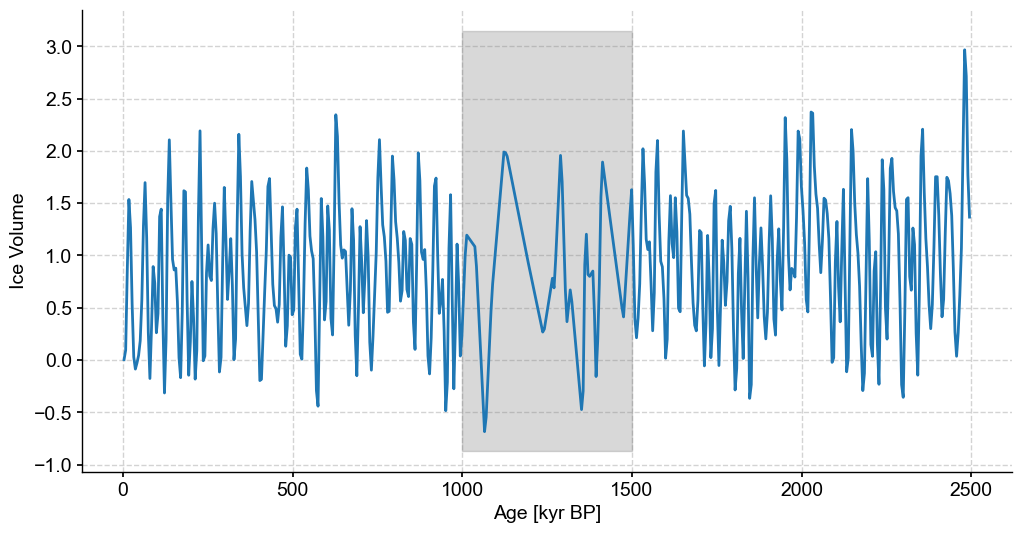

In [16]:
bounds = [1000,1500]

coarse_series = remove_values(series=stable_series,percent=80,subset=bounds).interp()
fig,ax = coarse_series.plot(legend=False,figsize=(12,6))

ylim=ax.get_ylim()
ax.fill_betweenx(ylim,min(bounds),max(bounds),color='grey',alpha=.3,label='Coarse Section')

In [17]:
series = coarse_series.interp()
m=12

amt_series = amt.Series(
    time=series.time,
    value=series.value,
    time_name = series.time_name,
    value_name = series.value_name,
    time_unit = series.time_unit,
    value_unit = series.value_unit,
    label = series.label,
    clean_ts=False
).convert_time_unit('Years')
td = amt_series.embed(m)
eps = td.find_epsilon(1,.05,.01,parallelize=False)
rm = eps['Output']
lp_coarse = rm.laplacian_eigenmaps(50,5).convert_time_unit('ka')

Time axis values sorted in ascending order
Initial density is 0.0029
Initial density is not within the tolerance window, searching...
Epsilon: 1.4707, Density: 0.0115
Epsilon: 1.8553, Density: 0.0472
Epsilon: 1.8553, Density: 0.0472.


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


Text(0.5, 0, 'Age [Kyr BP]')

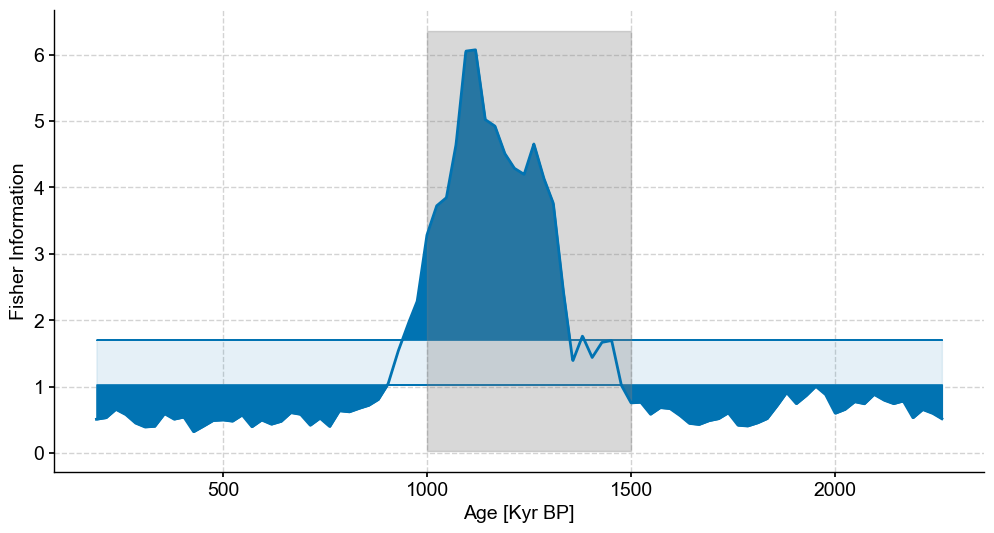

In [18]:
fig,ax = plt.subplots(figsize=(12,6))

lp_coarse.confidence_fill_plot(ax=ax,legend=False)
ylim = ax.get_ylim()
ax.fill_betweenx(ylim,min(bounds),max(bounds),color='grey',alpha=.3,label='Coarse Section')
ax.set_ylabel('Fisher Information')
ax.set_xlabel('Age [Kyr BP]')

# Full figure

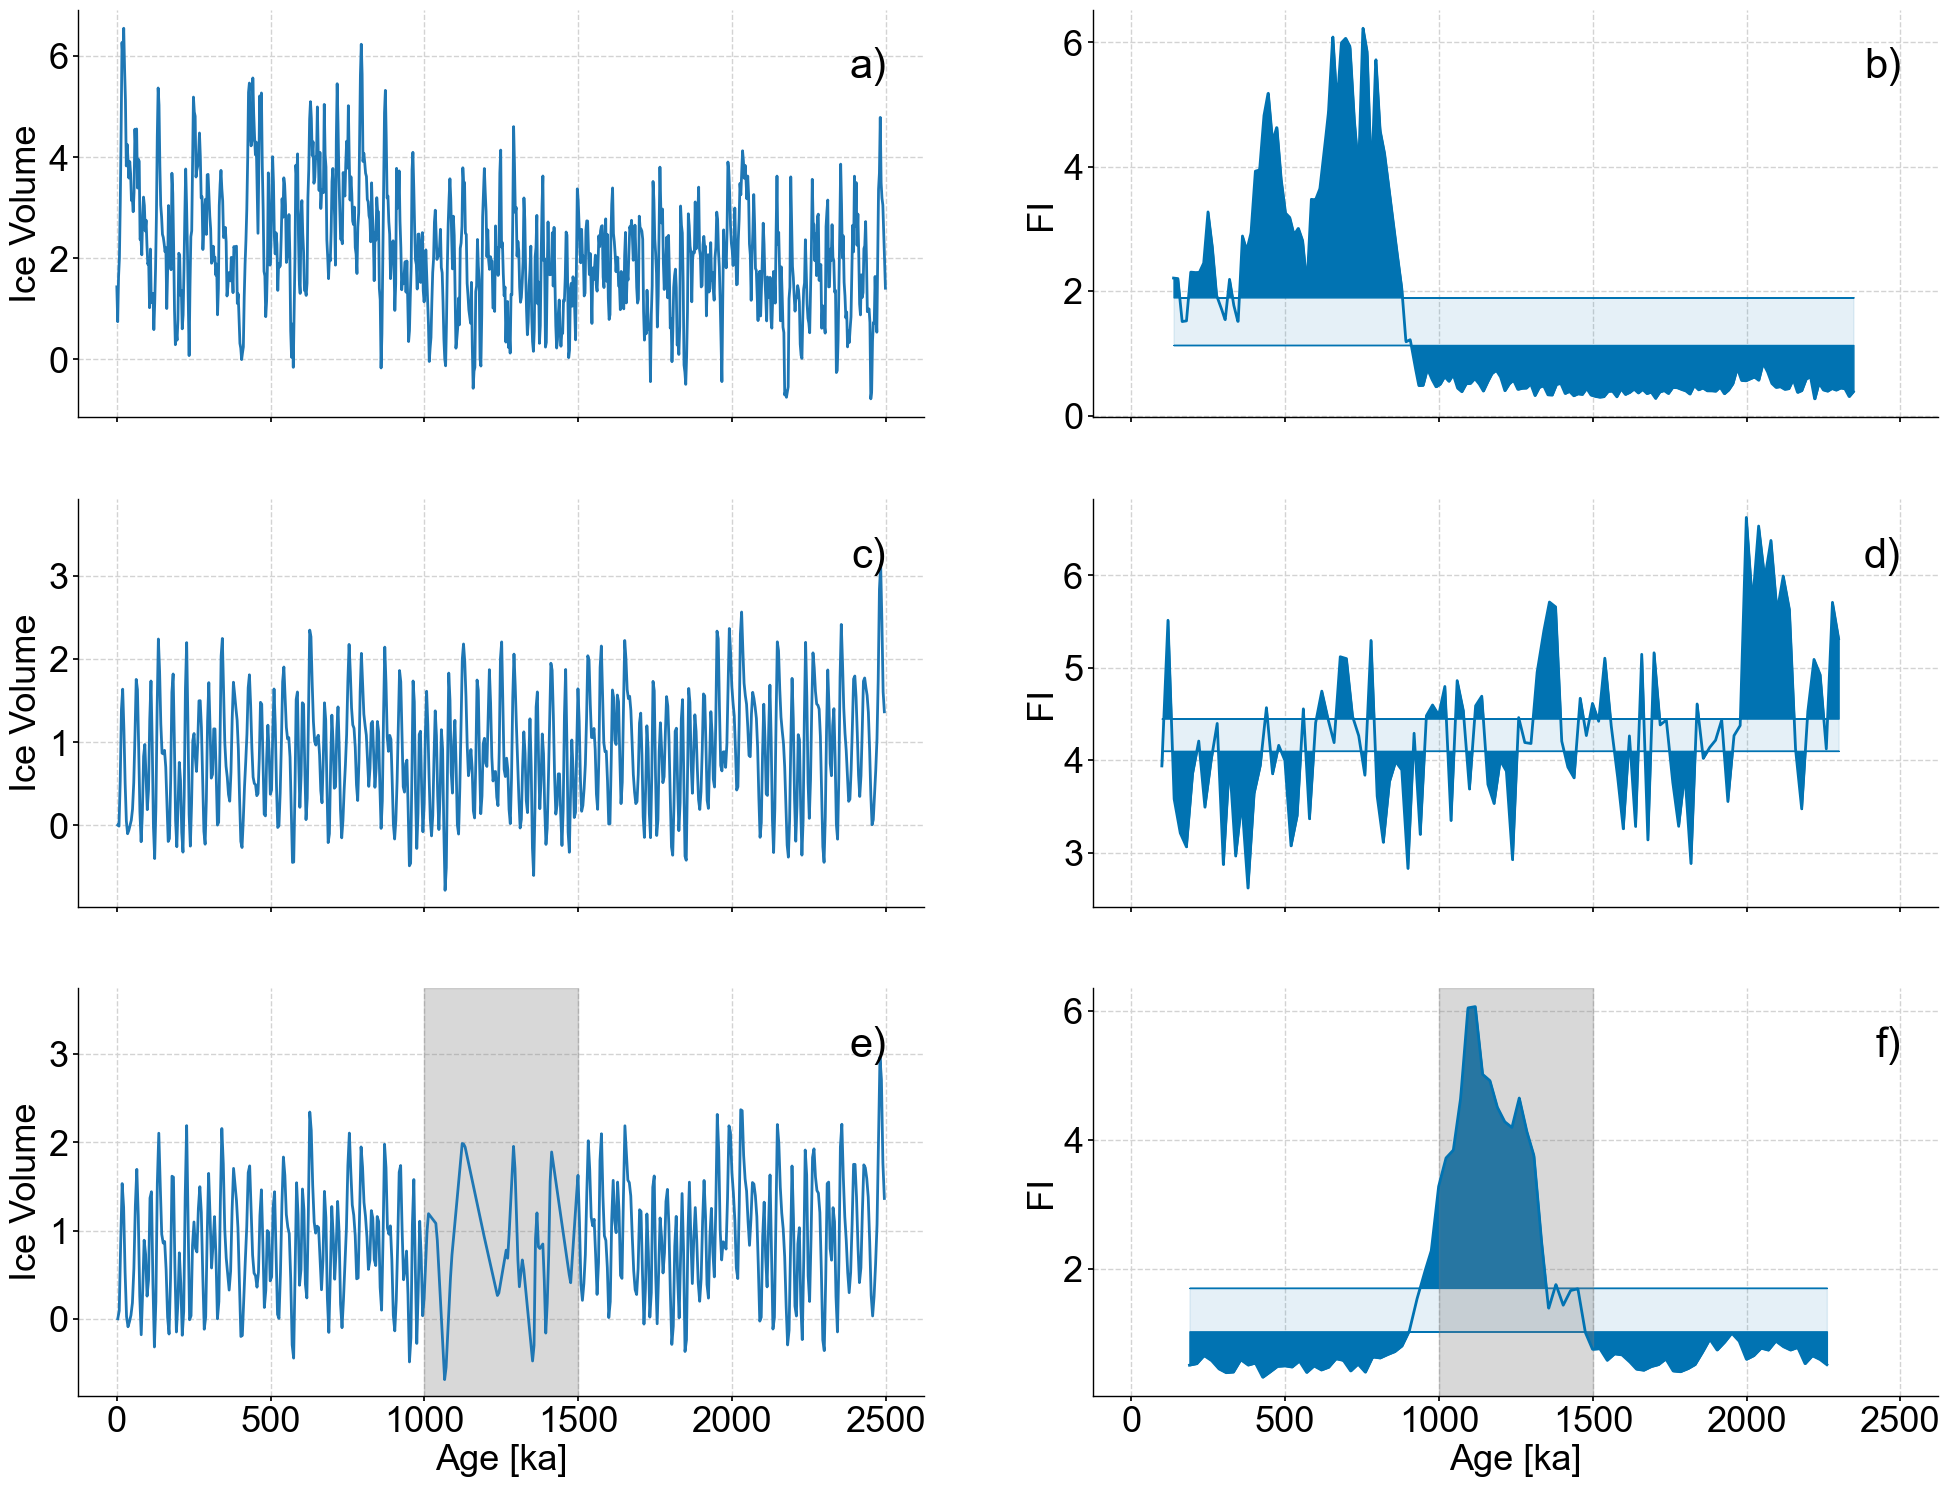

In [19]:
#Production figure

SMALL_SIZE = 26
MEDIUM_SIZE = 26
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,figsize=(24,18))

noisy_series_2.plot(ax=axes[0,0],legend=None,xlabel='')
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='a)')
axes[0,0].legend(handles=[patch],loc='upper right')

lp_series_2.confidence_fill_plot(ax=axes[0,1],legend=None,xlabel='',ylabel='FI')
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='b)')
axes[0,1].legend(handles=[patch],loc='upper right')

stable_series.plot(ax=axes[1,0],legend=None,xlabel='')
ylim=list(axes[1,0].get_ylim())
ylim[1]+=.6
axes[1,0].set_ylim(ylim)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='c)')
axes[1,0].legend(handles=[patch],loc='upper right')

lp_stable.confidence_fill_plot(ax=axes[1,1],legend=None,xlabel='',ylabel='FI')
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='d)')
axes[1,1].legend(handles=[patch],loc='upper right')

coarse_series.plot(ax=axes[2,0],legend=None,xlabel='Age [ka]')
ylim=list(axes[2,0].get_ylim())
ylim[1]+=.6
axes[2,0].fill_betweenx(ylim,min(bounds),max(bounds),color='grey',alpha=.3,label='Coarse Section')
axes[2,0].set_ylim(ylim)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='e)')
axes[2,0].legend(handles=[patch],loc='upper right')

lp_coarse.confidence_fill_plot(ax=axes[2,1],legend=None,ylabel='FI')
ylim=axes[2,1].get_ylim()
axes[2,1].fill_betweenx(ylim,min(bounds),max(bounds),color='grey',alpha=.3,label='Coarse Section')
axes[2,1].set_ylim(ylim)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='f)')
axes[2,1].legend(handles=[patch],loc='upper right')